# Simple egg box toy LogPDF

This LogPDF is based on a 2-dimensional distribution with 4 equal normal modes. Each mode is located in a different quadrant, and separated by a relatively large distance.

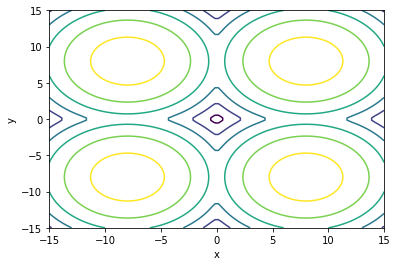

In [1]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
sigma = 2
r = 4
log_pdf = pints.toy.SimpleEggBoxLogPDF(sigma, r)

# Contour plot of pdf
levels = np.linspace(-100, 0, 20)
x = np.linspace(-15, 15, 100)
y = np.linspace(-15, 15, 100)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf([i, j]) for i in x] for j in y]
plt.contour(X, Y, Z, levels=levels)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

As an alternative visualisation, we can sample from the underlying distribution directly:

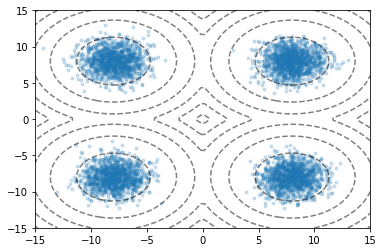

In [2]:
samples = log_pdf.sample(5000)
plt.figure()
plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.5)
plt.scatter(samples[:, 0], samples[:, 1], marker='.', alpha=0.2)
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.show()

We now try to sample from the distribution with a single chains of adaptive covariance MCMC, starting at a mode.

In [3]:
# Create an adaptive covariance MCMC routine
x0 = [[8, 8]]
mcmc = pints.MCMCController(log_pdf, 1, x0, method=pints.HaarioBardenetACMC)

# Stop after 6000 iterations
mcmc.set_max_iterations(4000)

# Disable logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Done!


We can inspect the convergence of the chains using a trace plot:

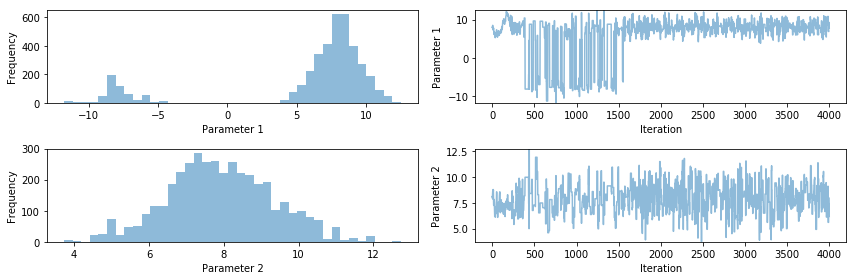

In [4]:
import pints.plot
pints.plot.trace(chains)
plt.show()

We then discard the warm-up, and stack the chains together to create a combined plot. If we're lucky, the chains will have explored different modes:

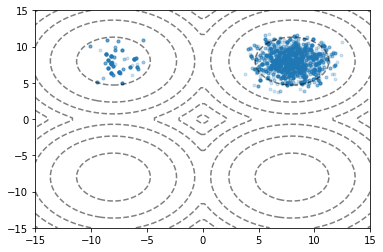

In [5]:
# Discard warm-up
chains = [chain[1000:] for chain in chains]

stacked = np.vstack(chains)
plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.show()

We can see that adaptive covariance MCMC doesn't (usually) perform very well on this type of problem at all!

Finally, we can calculate a "quality" score (based on Kullback-Leibler divergence) to assess how well we did on this problem:

In [6]:
print(log_pdf.kl_divergence(stacked))

65673.5722192


We can compare this to the direct sampling method:

In [7]:
print(log_pdf.kl_divergence(samples))

0.00501635799298


Try single population MCMC run with 5 parallel chains at various temperatures, again start chain at (8,8) mode.

Running...
Done!


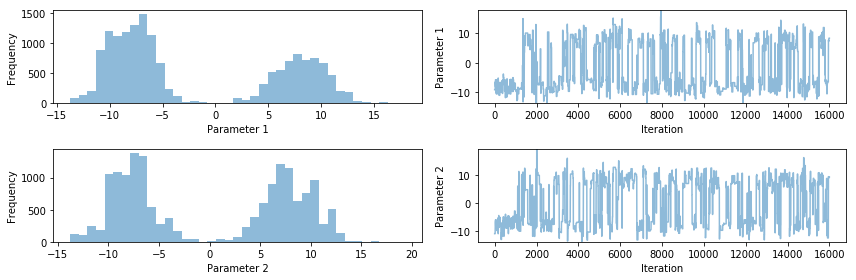

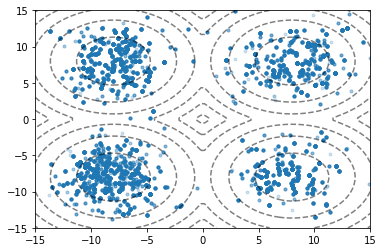

In [8]:
x0 = np.random.uniform(-15, 15, size=(1, 2))
sigma0 = [5, 5]
mcmc = pints.MCMCController(log_pdf, 1, x0, method=pints.PopulationMCMC, sigma0=sigma0)
mcmc.samplers()[0].set_temperature_schedule(5)

mcmc.set_initial_phase_iterations(1000)

# Stop after 8000 iterations
mcmc.set_max_iterations(16000)

# Disable logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

pints.plot.trace(chains)
plt.show()

stacked = np.vstack(chains)
plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.show()

In [9]:
chains = np.vstack(chains)
print('ESS:')
print(pints.effective_sample_size(chains))
print(log_pdf.kl_divergence(stacked))

ESS:
[128.7885990090073, 122.66188405524257]
5.3284628609


We see more frequent movement between modes by the chain at the correct temperature.

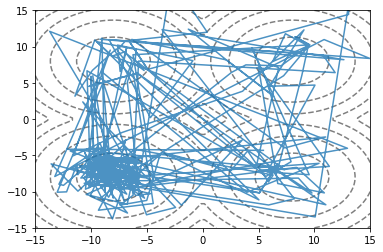

In [10]:
plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.5)
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.plot(chains[1:5000, 0], chains[1:5000, 1], alpha=0.8)
plt.show()